# Qubit gate decompositions of fermionic gates

In this page, we discuss the gate decompositions of the fermionic gates included in ffsim.

The following code cell constructs and draws an example circuit that uses some of the gates in ffsim. In the circuit drawing, the gates appear as opaque boxes. In the rest of this page, we'll see how these gates decompose into more basic gates.

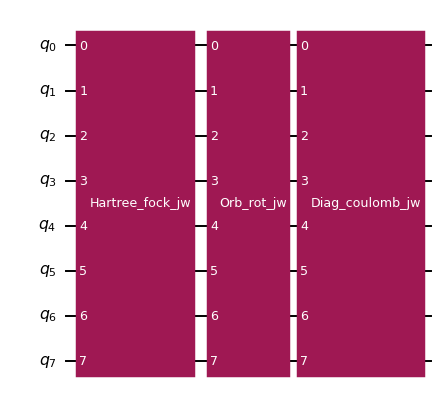

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister

import ffsim

# Let's use 4 spatial orbitals with 2 alpha electrons and 2 beta electrons.
norb = 4
nelec = (2, 2)

# Initialize qubits
qubits = QuantumRegister(2 * norb, name="q")

# Initialize random number generator
rng = np.random.default_rng(1234)

# Generate some random data
orbital_rotation = ffsim.random.random_unitary(norb, seed=rng)
diag_coulomb_mat = ffsim.random.random_real_symmetric_matrix(norb, seed=rng)

# Create an example circuit
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.OrbitalRotationJW(norb, orbital_rotation), qubits)
circuit.append(
    ffsim.qiskit.DiagCoulombEvolutionJW(norb, diag_coulomb_mat, time=1.0), qubits
)

# Draw the circuit
circuit.draw("mpl", scale=0.7)

## Hartree-Fock and Slater determinant preparation

Let's create a circuit with a Hartree-Fock state preparation gate, [PrepareHartreeFockJW](../api/ffsim.qiskit.rst#ffsim.qiskit.PrepareHartreeFockJW). Then, let's decompose the circuit once and draw the output.

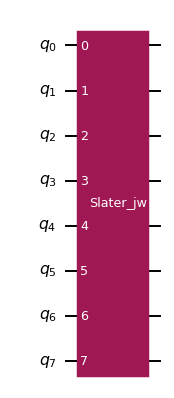

In [2]:
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)

circuit.decompose().draw("mpl", scale=0.7)

The Hartree-Fock preparation gate has decomposed into a Slater determinant preparation gate, [PrepareSlaterDeterminantJW](../api/ffsim.qiskit.rst#ffsim.qiskit.PrepareSlaterDeterminantJW). This makes sense, because the Hartree-Fock state is a special case of a Slater determinant. Let's go further and decompose the circuit using two repetitions.

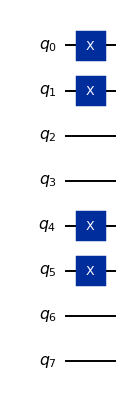

In [3]:
circuit.decompose(reps=2).draw("mpl", scale=0.7)

Finally, we see that the Hartree-Fock state preparation gate simply applies X gates to set the qubits corresponding to occupied orbitals to one.

The Hartree-Fock state is defined as having the lowest numbered orbitals occupied. If we want to produce a different electronic configuration, we can use a more general Slater determinant preparation gate. Let's do this using a configuration obtained from the Hartree-Fock configuration by exciting one of the spin $\alpha$ electrons to the next orbital.

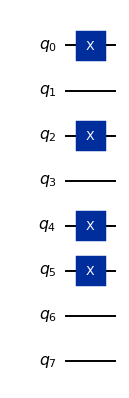

In [4]:
occupied_orbitals = ([0, 2], [0, 1])

circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareSlaterDeterminantJW(norb, occupied_orbitals), qubits)

circuit.decompose().draw("mpl", scale=0.7)

A general Slater determinant is obtained by applying an [orbital rotation](orbital-rotation.ipynb) to an electronic configuration. Let's generate a random orbital rotation and use it to initialize the Slater determinant preparation gate, [PrepareSlaterDeterminantJW](../api/ffsim.qiskit.rst#ffsim.qiskit.PrepareSlaterDeterminantJW).

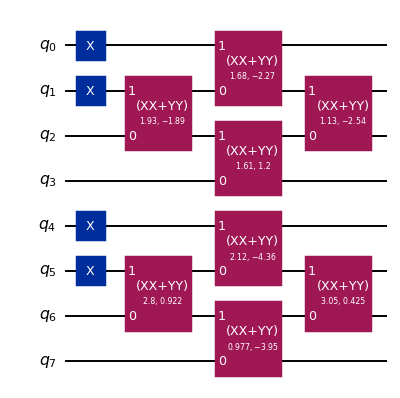

In [5]:
orbital_rotation = ffsim.random.random_unitary(norb, seed=rng)

circuit = QuantumCircuit(qubits)
circuit.append(
    ffsim.qiskit.PrepareSlaterDeterminantJW(
        norb, occupied_orbitals, orbital_rotation=orbital_rotation
    ),
    qubits,
)

circuit.decompose().draw("mpl", scale=0.7)

We see that the Slater determinant is prepared by applying X gates to prepare the Hartree-Fock configuration, and then applying a sequence of [XXPlusYYGates](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.XXPlusYYGate#xxplusyygate) to effect the orbital rotation. Note that the initial X gates prepare the Hartree-Fock configuration even though we specified a different one in the gate initialization. This happens because the Slater determinant gate decomposition is optimized to minimize the number of XXPlusYYGates in the result. The decomposition is more efficient than that of a general orbital rotation. The pattern of XXPlusYYGates requires only linear qubit connectivity.

## Orbital rotation

A general orbital rotation decomposes into a sequence of XXPlusYYGates followed by a layer of [PhaseGates](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PhaseGate#phasegate). As with the Slater determinant preparation, the pattern of XXPlusYYGates requires only linear qubit connectivity. Let's create a circuit with an [OrbitalRotationJW](../api/ffsim.qiskit.rst#ffsim.qiskit.OrbitalRotationJW) gate and see its decomposition.

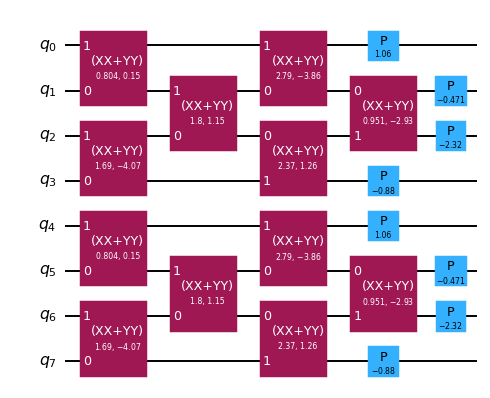

In [6]:
orbital_rotation = ffsim.random.random_unitary(norb, seed=rng)

circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.OrbitalRotationJW(norb, orbital_rotation), qubits)

circuit.decompose().draw("mpl", scale=0.7)

## Diagonal Coulomb evolution

Time evolution by a diagonal Coulomb Hamiltonian is implemented by the [DiagCoulombEvolutionJW](../api/ffsim.qiskit.rst#ffsim.qiskit.DiagCoulombEvolutionJW) gate. This gate decomposes into a layer of PhaseGates followed by a sequence of [CPhaseGates](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.CPhaseGate#cphasegate).

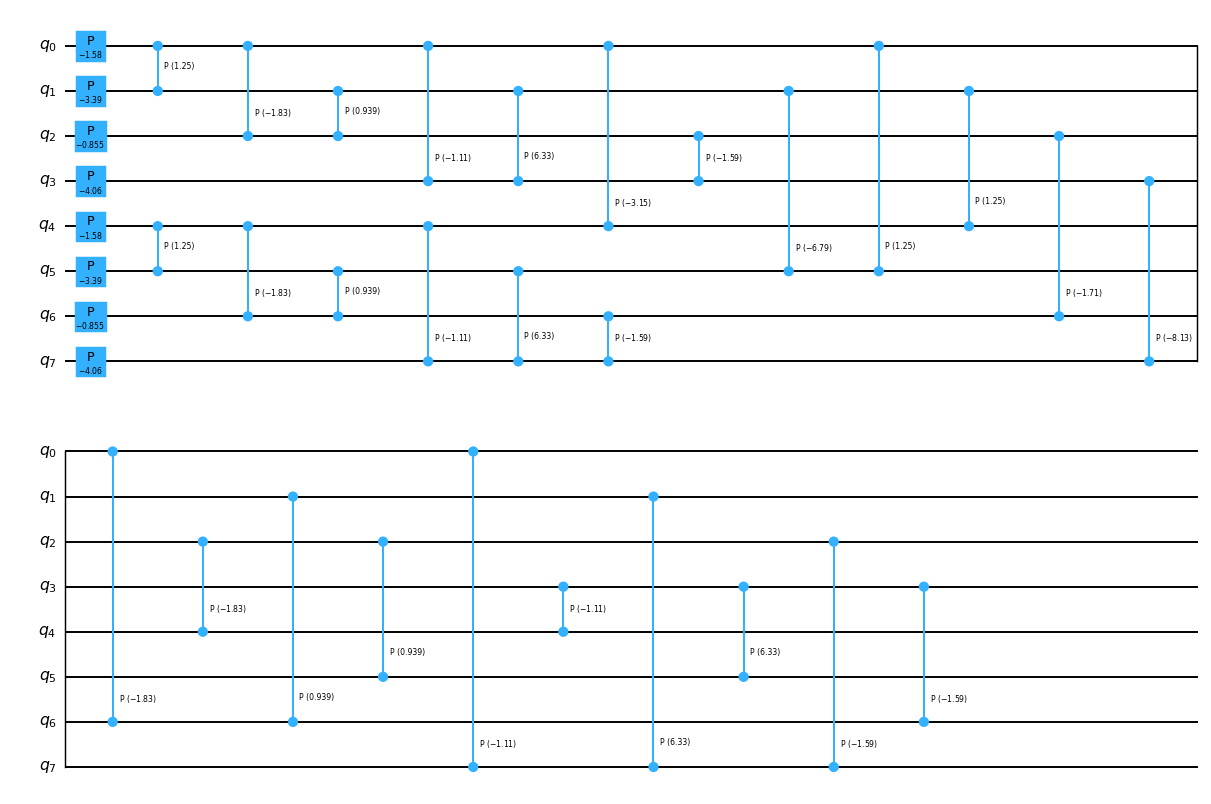

In [7]:
diag_coulomb_mat = ffsim.random.random_real_symmetric_matrix(norb, seed=rng)

circuit = QuantumCircuit(qubits)
circuit.append(
    ffsim.qiskit.DiagCoulombEvolutionJW(norb, diag_coulomb_mat, time=1.0), qubits
)

circuit.decompose().draw("mpl", scale=0.7)

## Unitary cluster Jastrow (UCJ) operator

There are several gate variants for the UCJ operator:

- [UCJOpSpinBalancedJW](../api/ffsim.qiskit.rst#ffsim.qiskit.UCJOpSpinBalancedJW)
- [UCJOpSpinUnbalancedJW](../api/ffsim.qiskit.rst#ffsim.qiskit.UCJOpSpinUnbalancedJW)

All variants decompose into a sequence of diagonal Coulomb evolutions sandwiched by orbital rotations. The number of diagonal Coulomb evolutions is equal to the number of ansatz repetitions (in this example, two).

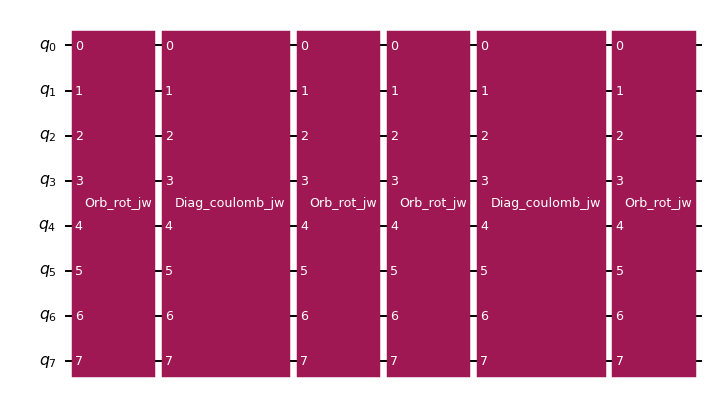

In [8]:
ucj_op = ffsim.random.random_ucj_op_spin_balanced(norb=norb, n_reps=2)

circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

circuit.decompose().draw("mpl", scale=0.7)

### Merging orbital rotations

The gate decomposition displayed above is not optimal because it contains adjacent orbital rotation gates, which can be merged. In [How to build and transpile Qiskit quantum circuits](../how-to-guides/qiskit-circuits.ipynb#Circuit-transpilation) we showed how to use ffsim's transpiler passes to optimize circuits constructed from fermionic gates. Here, we explain how this works in a bit more detail.

Consider a circuit that prepares the Hartree-Fock state and then applies a UCJ operator to it:

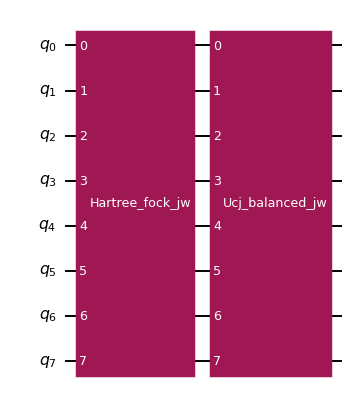

In [9]:
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

circuit.draw("mpl", scale=0.7)

Let's decompose the circuit once:

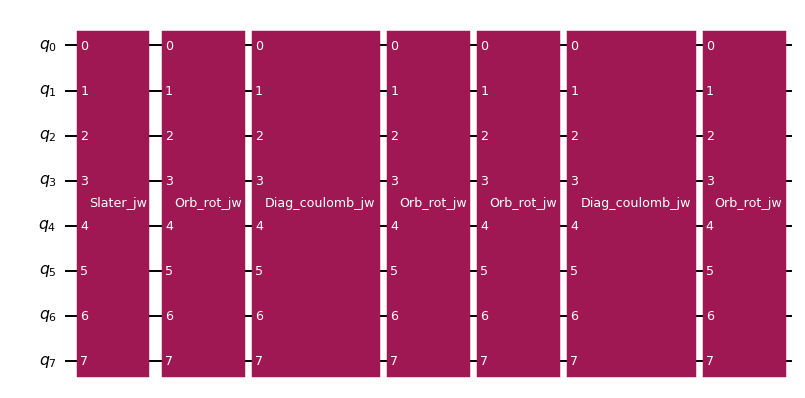

In [10]:
circuit.decompose().draw("mpl", scale=0.7)

There are two places that this circuit can be optimized:

- The first two gates can be merged into a single Slater determinant preparation gate.
- The fourth and fifth gates can be merged into a single orbital rotation gate.

The following code cell performs this optimization using a pass manager consisting of the [MergeOrbitalRotations](../api/ffsim.qiskit.rst#ffsim.qiskit.MergeOrbitalRotations) pass.

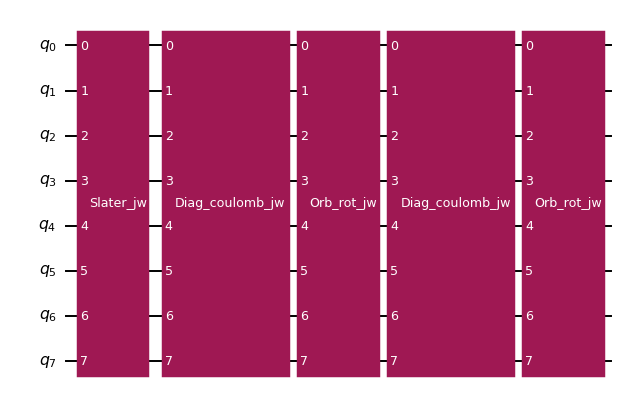

In [11]:
from qiskit.transpiler import PassManager

pass_manager = PassManager([ffsim.qiskit.MergeOrbitalRotations()])
transpiled = pass_manager.run(circuit.decompose())

transpiled.draw("mpl", scale=0.7)

Note that the MergeOrbitalRotations pass needs to be run on the decomposed circuit. Running it on the original circuit will have no effect because the orbital rotations are not exposed:

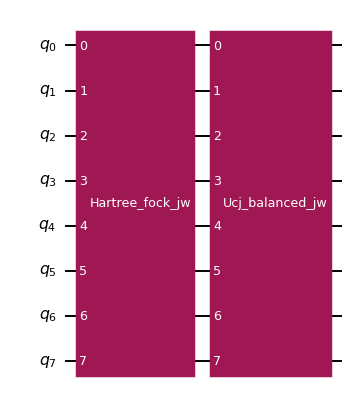

In [12]:
transpiled = pass_manager.run(circuit)

transpiled.draw("mpl", scale=0.7)

This issue can addressed by adding a [Decompose](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Decompose#decompose) pass that decomposes Hartree-Fock and UCJ gates before the MergeOrbitalRotations pass:

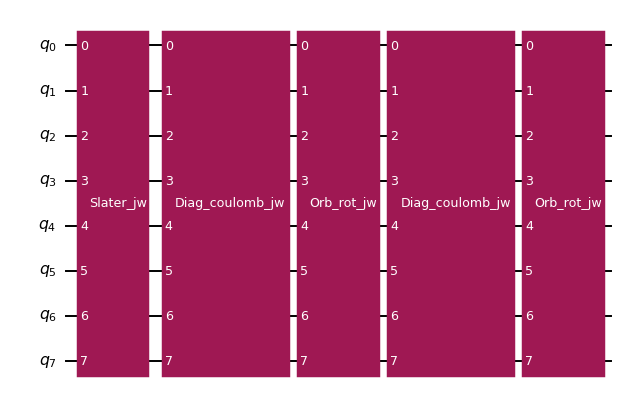

In [13]:
from qiskit.transpiler.passes import Decompose

pass_manager = PassManager(
    [
        Decompose(["hartree_fock_jw", "ucj_balanced_jw"]),
        ffsim.qiskit.MergeOrbitalRotations(),
    ]
)
transpiled = pass_manager.run(circuit)

transpiled.draw("mpl", scale=0.7)

The [ffsim.qiskit.PRE_INIT](../api/ffsim.qiskit.rst#ffsim.qiskit.PRE_INIT) constant stores a pass manager with transpiler passes that decompose gates into orbital rotations and then merges them. The constant is so named because we recommend using it for the `pre_init` stage of Qiskit's transpiler pipeline.

Let's do a full transpilation of the circuit with and without the `PRE_INIT` pass manager, and then print the final gate counts.

In [14]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Initialize quantum device backend
backend = GenericBackendV2(2 * norb, basis_gates=["cp", "xx_plus_yy", "p", "x"])

# Create a pass manager for circuit transpilation
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

# Transpile the circuit without pre_init passes
transpiled = pass_manager.run(circuit)

# Transpile the circuit with pre_init passes
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
transpiled_opt = pass_manager.run(circuit)

print("Gate counts without PRE_INIT passes:")
print(transpiled.count_ops())
print()
print("Gate counts with PRE_INIT passes:")
print(transpiled_opt.count_ops())

Gate counts without PRE_INIT passes:
OrderedDict({'cp': 56, 'xx_plus_yy': 48, 'p': 32, 'x': 4})

Gate counts with PRE_INIT passes:
OrderedDict({'cp': 56, 'xx_plus_yy': 32, 'p': 24, 'x': 4})


The XXPlusYYGate count is significantly reduced when the `PRE_INIT` pass manager is used.

### Locality in the UCJ operator

Recall that the UCJ operator decomposes into orbital rotations and diagonal Coulomb evolutions. As explained [previously](#Orbital-rotation), orbital rotations decompose into a pattern of XXPlusYYGates that can be implemented using only linear qubit connectivity. However, the diagonal Coulomb evolutions decompose into a pattern of controlled phase gates which in general require all-to-all connectivity, and their implementation on a limited connectivity qubit device would involve the insertion of swap gates. The following code cell constructs a UCJ operator with a single ansatz repetition, decomposes its diagonal Coulomb evolution, and draws the resulting circuit, showing the high number of controlled phase gates.

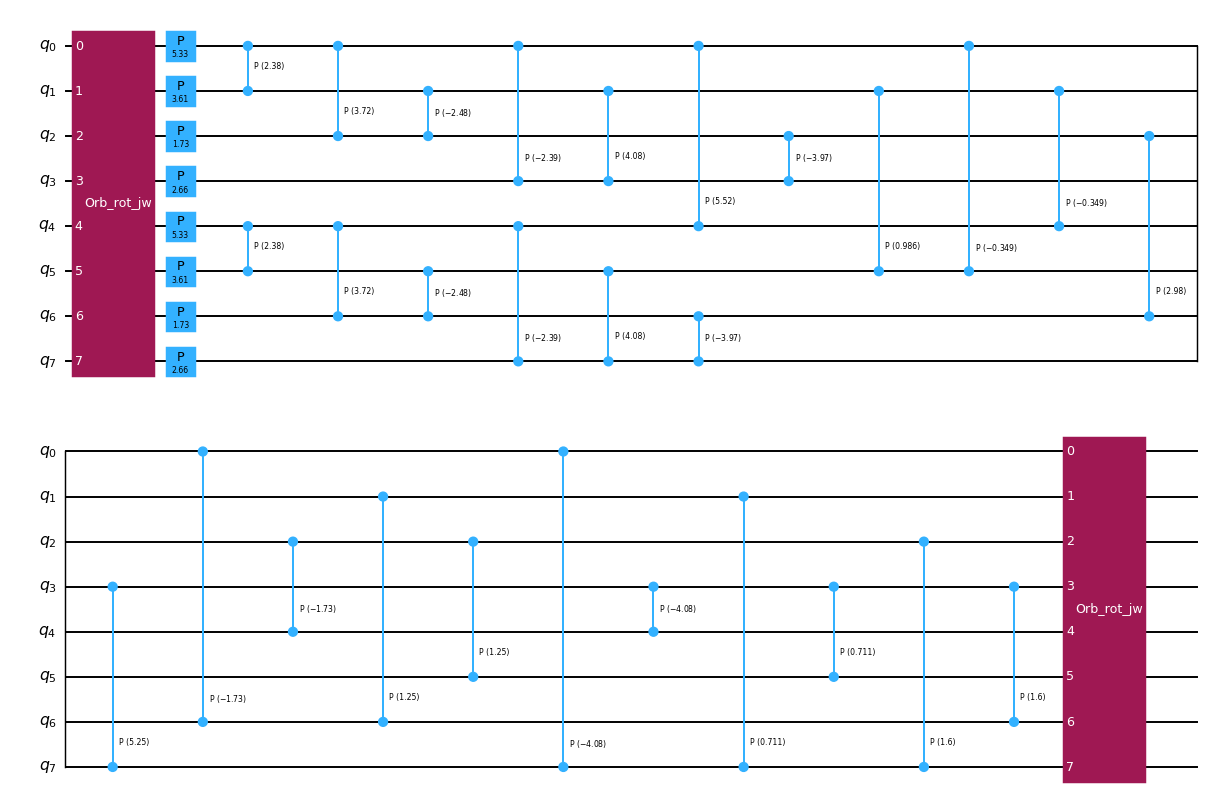

In [15]:
ucj_op = ffsim.random.random_ucj_op_spin_balanced(norb=norb, n_reps=1)

circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

circuit.decompose(["ucj_balanced_jw", "diag_coulomb_jw"], reps=2).draw("mpl", scale=0.7)

The local UCJ (LUCJ) ansatz is more amenable to qubit hardware with limited connectivity. It works by allowing diagonal Coulomb interactions only between certain pairs of orbitals, with the choice of interactions motivated by the connectivity of the target hardware. As explained in [The local unitary cluster Jastrow (LUCJ) ansatz](lucj.ipynb#The-local-UCJ-(LUCJ)-ansatz), if interactions between orbitals of the same spin are restricted to a line topology and interactions between orbitals of opposing spins allowed only within the same spatial orbital, then the diagonal Coulomb interactions can be implemented directly on a square lattice topology without swap gates by mapping the $\alpha$ and $\beta$ orbitals onto adjacent parallel lines. The following code cell shows how to add these restrictions.

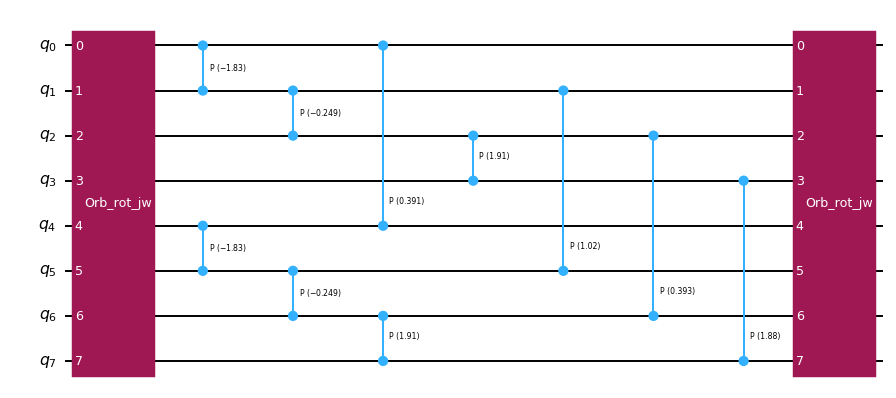

In [16]:
pairs_aa = [(p, p + 1) for p in range(norb - 1)]
pairs_ab = [(p, p) for p in range(norb)]

n_params = ffsim.UCJOpSpinBalanced.n_params(
    norb=norb, n_reps=1, interaction_pairs=(pairs_aa, pairs_ab)
)
ucj_op = ffsim.UCJOpSpinBalanced.from_parameters(
    rng.standard_normal(n_params),
    norb=norb,
    n_reps=1,
    interaction_pairs=(pairs_aa, pairs_ab),
)

circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

circuit.decompose(["ucj_balanced_jw", "diag_coulomb_jw"], reps=2).draw("mpl", scale=0.7)

Now, there are much fewer controlled-phase gates, and the gates that are retained act on neighboring qubits if the orbitals are mapped onto a square lattice as described above.